<a href="https://colab.research.google.com/github/alan-vieira/datascience/blob/main/text_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy pyLDAvis

In [2]:
!python -m spacy download pt_core_news_sm

✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk import word_tokenize
from nltk.util import ngrams
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Conjunto de dados

In [5]:
news = pd.read_csv("https://www.dropbox.com/s/p3ywl8wpm2rzzk2/articles.csv?dl=1")

In [6]:
news.head()

,title,text,date,category,subcategory,link
0,"Lula diz que está 'lascado', mas que ainda tem...",Com a possibilidade de uma condenação impedir ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
1,"'Decidi ser escrava das mulheres que sofrem', ...","Para Oumou Sangaré, cantora e ativista malines...",2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
2,Três reportagens da Folha ganham Prêmio Petrob...,Três reportagens da Folha foram vencedoras do ...,2017-09-10,poder,NaN,http://www1.folha.uol.com.br/poder/2017/10/192...
3,Filme 'Star Wars: Os Últimos Jedi' ganha trail...,A Disney divulgou na noite desta segunda-feira...,2017-09-10,ilustrada,NaN,http://www1.folha.uol.com.br/ilustrada/2017/10...
4,CBSS inicia acordos com fintechs e quer 30% do...,"O CBSS, banco da holding Elopar dos sócios Bra...",2017-09-10,mercado,NaN,http://www1.folha.uol.com.br/mercado/2017/10/1...


Filtrar por turismo

In [7]:
turismo = news[news['category'] == 'turismo']

In [8]:
turismo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1903 entries, 381 to 167031
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        1903 non-null   object
 1   text         1903 non-null   object
 2   date         1903 non-null   object
 3   category     1903 non-null   object
 4   subcategory  0 non-null      object
 5   link         1903 non-null   object
dtypes: object(6)
memory usage: 104.1+ KB


In [9]:
def limpa_texto(texto):
  # remove caracreres no fim de uma linha
	c = re.sub(r'\n', ' ', texto)
	c = re.sub(r'\n', ' ', c)
	
  # remove caracteres alfanumericos
	c = c.replace(':', '')
  # removendo barra caso exista no texto
	c = c.replace('/', '')
  # removendo R$ por vazio
	c = re.sub(r'R\$', '', c)
	c = re.sub(r'\W', ' ', c)
	
  ## removendo multiplos espaços
	c = re.sub(r'\s+', ' ', c)
 
  ## dando um trim na frase (removendo espaços no inicio e final de uma frase)
	c = re.sub(r'^\s+', '', c)
	c = re.sub(r'\s+$', '', c)
	
	return c.lower()

In [10]:
from spacy.lang.pt import Portuguese

In [11]:
STOP_WORDS = spacy.lang.pt.stop_words.STOP_WORDS

In [12]:
STOP_WORDS

{'acerca',
 'ademais',
 'adeus',
 'agora',
 'ainda',
 'algo',
 'algumas',
 'alguns',
 'ali',
 'além',
 'ambas',
 'ambos',
 'antes',
 'ao',
 'aos',
 'apenas',
 'apoia',
 'apoio',
 'apontar',
 'após',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aqui',
 'aquilo',
 'as',
 'assim',
 'através',
 'atrás',
 'até',
 'aí',
 'baixo',
 'bastante',
 'bem',
 'boa',
 'bom',
 'breve',
 'cada',
 'caminho',
 'catorze',
 'cedo',
 'cento',
 'certamente',
 'certeza',
 'cima',
 'cinco',
 'coisa',
 'com',
 'como',
 'comprida',
 'comprido',
 'conhecida',
 'conhecido',
 'conselho',
 'contra',
 'contudo',
 'corrente',
 'cuja',
 'cujo',
 'custa',
 'cá',
 'da',
 'daquela',
 'daquele',
 'dar',
 'das',
 'de',
 'debaixo',
 'demais',
 'dentro',
 'depois',
 'des',
 'desde',
 'dessa',
 'desse',
 'desta',
 'deste',
 'deve',
 'devem',
 'deverá',
 'dez',
 'dezanove',
 'dezasseis',
 'dezassete',
 'dezoito',
 'diante',
 'direita',
 'disso',
 'diz',
 'dizem',
 'dizer',
 'do',
 'dois',
 'dos',
 'doze',
 'duas',
 'dá',
 'd

In [13]:
def remove_stop(texto):
  doc = nlp_pt(texto)
  return " ".join(x.text for x in doc if x.text not in STOP_WORDS)

In [14]:
def limpa_texto2(texto):
  doc = nlp_pt(texto)
  return " ".join(x.lemma_ for x in doc if x.text not in STOP_WORDS)

# Análise Exploratória

1. número de palavras no título das notícias

In [15]:
turismo['title_n_words'] = turismo['title'].apply(lambda x : len(x.split()))

In [16]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10


In [17]:
turismo.describe()

,title_n_words
count,1903.000000
mean,10.923805
std,1.812440
min,4.000000
25%,10.000000
50%,11.000000
75%,12.000000
max,20.000000


2. Número de caracteres no título das notícias

In [18]:
turismo['title_n_chars'] = turismo['title'].apply(lambda x : len(x.replace(" ", "")))

In [19]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62


In [20]:
turismo.describe()

,title_n_words,title_n_chars
count,1903.000000,1903.000000
mean,10.923805,55.666842
std,1.812440,6.309523
min,4.000000,25.000000
25%,10.000000,52.000000
50%,11.000000,57.000000
75%,12.000000,60.000000
max,20.000000,87.000000


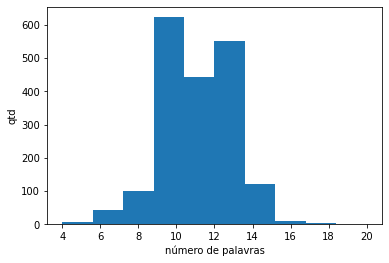

In [21]:
turismo.title_n_words.hist();
plt.xlabel('número de palavras')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

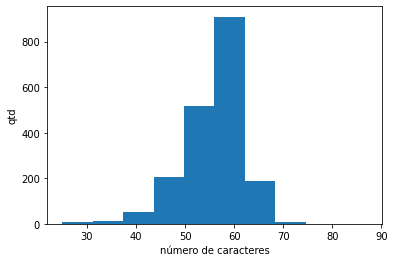

In [22]:
turismo.title_n_chars.hist();
plt.xlabel('número de caracteres')
plt.ylabel('qtd')
plt.grid(b=None)
plt.show()

# Limpeza dos dados

In [47]:
nlp_pt = spacy.load('pt_core_news_sm')

In [48]:
rev = turismo.iloc[0]['title']

In [49]:
rev

'Latam inaugura voo direto de 15 horas entre Chile e Austrália'

In [50]:
rev = limpa_texto(rev)

In [51]:
rev

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [52]:
rev2 = turismo.iloc[5]['title']

In [53]:
rev2

"'Viagem ao Japão é aula de cultura e tradição', diz ator Jayme Matarazzo"

In [54]:
limpa_texto(rev2)

'viagem ao japão é aula de cultura e tradição diz ator jayme matarazzo'

In [55]:
rev = nlp_pt(rev)

In [56]:
def exibe_token(texto):
  col_names = ['ALPHA', 'PUNCT', 'LIKE NUM', 'POS']
  formatted_text = '{:>16}' * (len(col_names) + 1)
  print('\n', formatted_text.format('INPUT WORD', *col_names), '\n', '='*130)

  for token in texto:
    output = [token.text, token.is_alpha, token.is_punct, token.like_num, token.pos_]
    print(formatted_text.format(*output))

In [57]:
exibe_token(rev)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
           latam               1               0               0            VERB
        inaugura               1               0               0            VERB
             voo               1               0               0            VERB
          direto               1               0               0             ADV
              de               1               0               0             ADP
              15               0               0               1             NUM
           horas               1               0               0            NOUN
           entre               1               0               0             ADP
           chile               1               0               0           PROPN
               e               1               0               0           CCONJ
       austrália               1               0               0           PROPN


In [58]:
from spacy import displacy

In [59]:
displacy.render(rev, style='dep', jupyter=True)

In [60]:
rev2 = nlp_pt(rev2)

In [61]:
exibe_token(rev2)


       INPUT WORD           ALPHA           PUNCT        LIKE NUM             POS 
               '               0               1               0           PUNCT
          Viagem               1               0               0            NOUN
               a               1               0               0             ADP
               o               1               0               0             DET
           Japão               1               0               0           PROPN
               é               1               0               0            VERB
            aula               1               0               0            NOUN
              de               1               0               0             ADP
         cultura               1               0               0            NOUN
               e               1               0               0           CCONJ
        tradição               1               0               0            NOUN
               '         

In [62]:
turismo['title_clean'] = turismo['title'].apply(lambda x : limpa_texto(x))

In [63]:
turismo.head()

,title,text,date,category,subcategory,link,title_n_words,title_n_chars,title_clean,title_clean_no_stop,title_lemmas
381,Latam inaugura voo direto de 15 horas entre Ch...,Animem-se os que pretendem cruzar o Pacífico e...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,51,latam inaugura voo direto de 15 horas entre ch...,latam inaugura voo direto 15 horas chile e aus...,latir inaugurar voar direto 15 horar chile e a...
414,Turismo de Las Vegas deve se recuperar em mese...,O massacre em Las Vegas afetará o turismo da c...,2017-06-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,54,turismo de las vegas deve se recuperar em mese...,turismo las vegas recuperar analistas,turismo o vegas recuperar analista
522,Brasileiro cria app para economizar no passeio...,"Com cerca de 50 mil visitantes por dia, Veneza...",2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,11,58,brasileiro cria app para economizar no passeio...,brasileiro cria app economizar passeio gôndola...,brasileiro criar app economizar passear gôndol...
602,AirBnB passa a fazer reserva de restaurantes,A plataforma de hospedagem Airbnb anunciou que...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,7,38,airbnb passa a fazer reserva de restaurantes,airbnb passa a reserva restaurantes,airbnb passar o reservar restaurante
609,Museus lembram quatro décadas de opressão sovi...,Nos países que viveram sob a órbita da União S...,2017-05-10,turismo,NaN,http://www1.folha.uol.com.br/turismo/2017/10/1...,10,62,museus lembram quatro décadas de opressão sovi...,museus lembram décadas opressão soviética países,museu lembrar década opressão soviético país


In [64]:
turismo['title_clean_no_stop'] = turismo['title_clean'].apply(lambda x : remove_stop(x))

In [65]:
turismo.iloc[0]['title_clean']

'latam inaugura voo direto de 15 horas entre chile e austrália'

In [66]:
turismo.iloc[0]['title_clean_no_stop']

'latam inaugura voo direto 15 horas chile e austrália'

In [67]:
# Lematização

turismo['title_lemmas'] = turismo['title_clean_no_stop'].apply(lambda x : limpa_texto2(x))

In [68]:
turismo.iloc[0]['title_lemmas']

'latir inaugurar voar direto 15 horar chile e austrália'

In [69]:
turismo.iloc[5]['title_lemmas']

'viagem o o japão aula cultura e tradição ator jayme matarazzo'

In [70]:
# N-grams

In [73]:
titulos = " ".join(turismo['title_lemmas'])

In [74]:
token = word_tokenize(titulos)

In [75]:
bigrams = ngrams(token,2 )

In [76]:
print(Counter(bigrams).most_common(10))

[(('o', 'o'), 91), (('fotógrafo', 'registrar'), 39), (('atrair', 'turista'), 25), (('fotógrafo', 'clicar'), 23), (('álbum', 'viagem'), 22), (('companhia', 'aéreo'), 20), (('turista', 'o'), 20), (('o', 'turismo'), 20), (('viagem', 'o'), 18), (('e', 'o'), 18)]


In [77]:
trigrams = ngrams(token,3 )

In [78]:
print(Counter(trigrams).most_common(10))

[(('voltar', 'o', 'o'), 8), (('atrair', 'turista', 'o'), 7), (('fotógrafo', 'registrar', 'o'), 7), (('museu', 'dedicar', 'o'), 6), (('o', 'o', 'redor'), 6), (('o', 'o', 'mundo'), 6), (('o', 'o', 'público'), 6), (('viagem', 'o', 'o'), 5), (('fotógrafo', 'registrar', 'paisagem'), 5), (('o', 'redor', 'mundo'), 5)]


In [79]:
vectorizer = CountVectorizer(min_df=10, max_df= 0.9, stop_words=STOP_WORDS, lowercase=True)

In [81]:
data_vectorized = vectorizer.fit_transform(turismo['title_lemmas'])

In [82]:
NUM_TOPICS = 2

In [84]:
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=30, learning_method='online', verbose=True)

In [85]:
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30


In [86]:
import pyLDAvis.sklearn

In [87]:
pyLDAvis.enable_notebook()

In [88]:
dash = pyLDAvis.sklearn.prepare(lda, data_vectorized, vectorizer,mds='tsne')

In [89]:
dash

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  51.680567
1      60.312561 -141.369141       2        1  48.319433, topic_info=          Term        Freq       Total Category  logprob  loglift
214    turista  188.000000  188.000000  Default  30.0000  30.0000
221     viagem  115.000000  115.000000  Default  29.0000  29.0000
103  fotógrafo  101.000000  101.000000  Default  28.0000  28.0000
213    turismo  112.000000  112.000000  Default  27.0000  27.0000
138      mundo   82.000000   82.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
114      hotel  100.202214  105.922343   Topic2  -3.3024   0.6718
49       chino   24.712108   25.501963   Topic2  -4.7023   0.6959
137    mostrar   28.291173   29.359612   Topic2  -4.5670   0.6903
28       avião   24.437507   25.855613   Topic2  -4.7135   0.6709
50      cidade   39.971464   79.789185   Topic2  -4.2214   0.0361

[104 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
6         1  0.972064   abrir
6         2  0.032402   abrir
9         1  0.992575  airbnb
9         2  0.039703  airbnb
18        1  0.013547     ano
...     ...       ...     ...
236       1  0.042100    york
236       2  0.968310    york
238       1  0.037066    água
238       2  0.963711    água
239       2  0.968863   álbum

[145 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])